# ECON 148 Lab

In this lab, we will look at the concept of survival analysis. Survival analysis looks at the time until an event occurs (failure) or if we lose them from the sample (censored observation). As economists, we are interested in how long they stay in the sample (survival). We are also interested in the risk of failure (hazard rates).

Some applications of survival analysis inclue:
 * Firm survival and exit from a market.
 * Time to retirement.
 * How long a machine will last.
 * Likelihood a patient will survive after recieving a diagnosis.
 * How long before a customer will change companies or _churn_.

## Math/Stat Intuition

Let's take a non-negative continuous random variable $T$ to represent time.

As a continuous random variable, $T$ has both a probability density function (pdf) and a cumulative density function (cdf). $T$ will have pdf $f(t)$ and cdf $F(T)$.

Using the properties of pdfs, we can express the cdf as:

$$F(t)=P(T<t)$$

In this, $F(t)$ gives us the probability that the event has occured by duration $t$. This also means that $F(t)$ gives us the proportion of population with the time to event value less than $t$.

We can also express the cdf as an integral of the pdf:

$$\int_{0}^{t}f(x)dx$$

**Survival Function**

Using the cdf, we can calculate the survival function, or the probability that the event has not occurred by the time $t$. This means that, S(t) gives us the proportion of population with the time to event value more than t. The survival function looks like:

$$S(t)=1-F(t)=P(T\geq t)$$

We can also express this as an integral:

$$\int_{t}^{\infty}f(x)dx$$

Because we don't know the true cdf or pdf for the event we are analyzing, we will use a statistical tool called the Kaplan-Meier estimate to help us.

## Kaplan-Meier Estimate

As mentioned above, we will likely not have the cdf or pdf available for a real world application of survival analysis. Rather, we will have to estimate the survival function from the available data. For this, we will utilize a Kaplan-Meier Estimate. 

$$\hat{S}=\prod_{i:t_{i}\leq t}\frac{n_{i}-d_{i}}{n_{i}}$$

In the estimate, denoted by $\hat{S}$, $n_{i}$ is the population at risk at the time just prior to $t_{i}$. $d_{i}$ is the number of events that have occured at time $t_{i}$.

For this notebook, we will be using Python to help us do the calculations. Don't worry if the formula is a little difficult to understand. The basic idea to know is that we are creating a survival curve using observed data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
%pylab inline
figsize(12,6)
pd.set_option('display.max_columns', None)
from lifelines import KaplanMeierFitter

Populating the interactive namespace from numpy and matplotlib


Let's look at an example using some toy data. As mentioned above, we'll be using the `lifelines` Python package to help us compute these survival curves.

<AxesSubplot:xlabel='timeline'>

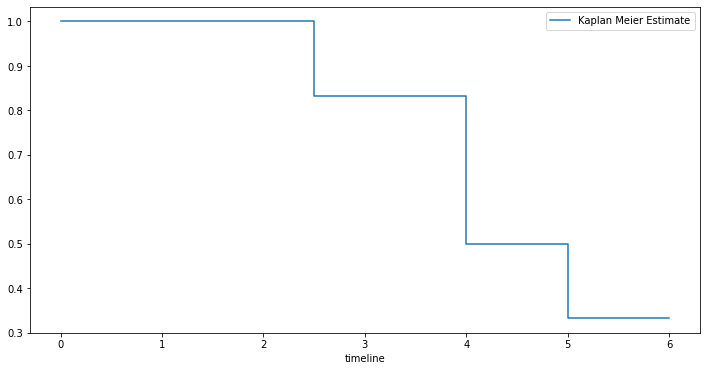

In [2]:
## Example Data 
durations = [5,6,6,2.5,4,4]
event_observed = [1, 0, 0, 1, 1, 1]

## create an kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
kmf.plot(ci_show=False)

See how the survival curve approximates the data we have observed? Now that we have seen this in action, let's take a look at a real world example using some more complex data.

### Telco Customer Churn

This dataset looks at customer churn for a telco company.

The data set includes information about:
 * Customers who left within the last month – the column is called Churn
 * Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
 *  Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
 *  Demographic info about customers – gender, age range, and if they have partners and dependents


Let's read in the data and take a look at the first couple of rows. The data comes from Kaggle and can be accessed [here]("https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download").

In [3]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df["Churn"]=df["Churn"].replace({"No":0,"Yes":1})

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [5]:
df["TotalCharges"]=pd.to_numeric(df["TotalCharges"],errors="coerce")

In [6]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Because the Kaplan-Meier process requires numeric values for the features we use, we'll have to do some cleaning and transformations. We'll also have to fill in some NaN values.

In [7]:
df["TotalCharges"].fillna(value=df['TotalCharges'].median(),inplace=True)

Now that we have cleaned the data, let's create a Kaplan-Meier curve.

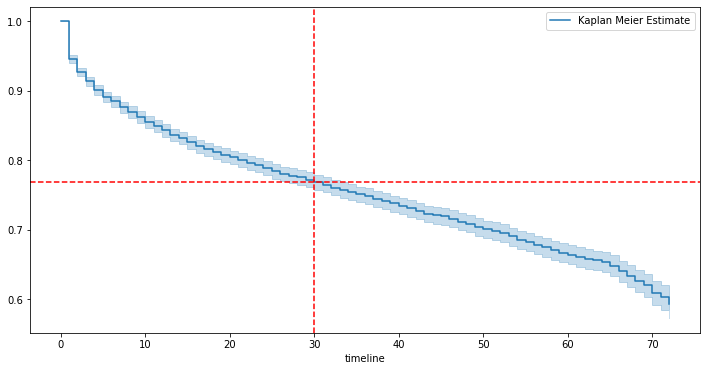

In [8]:
durations = df['tenure'] 
event_observed = df['Churn'] 

km = KaplanMeierFitter() 

km.fit(durations, event_observed,label='Kaplan Meier Estimate')

km.plot()
plt.axhline(km.survival_function_at_times(30).item(),color="red",linestyle='dashed')
plt.axvline(30, color="red",linestyle='dashed');

What does this curve mean? For example, if we look at $t=30$, there is a 76% chance that a customer will not churn after that point.

## Credit Risk

Let's look at another application of survival analysis: credit risk. Credit Risk refers to the likelihood that a borrower will not be able to repay a loan contracted by a lender. Thus throughout the years, financial institutions have developed various ways to quantify that risk so as to limit their exposure.

Here, instead of simply modeling whether a borrower will repay, by using Survival Analysis, it becomes possible to determine when this will happen. Indeed, it is easy to consider that fully repaying a loan is an explicit event, and therefore not having paid back the loan yet can be defined as the censored situation.

By using this configuration, banks, credit unions, or fintech startups in the lending space can predict the speed of repayment of a loan. This will help these institutions mitigate losses due to bad debt, customize interest rates, improve cash flow and credit collections, and determine which customers are likely to bring in the most revenue throughout a variety of products.

Let's start by reading in the data. The data comes from the [UCI Machine Learning Repository]("https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)") and has been reformatted into CSV format [here]("https://github.com/selva86/datasets/blob/master/GermanCredit.csv").

In [9]:
credit = pd.read_csv("data/GermanCredit.csv")

In [10]:
credit.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,... < 100 DM,6,critical account/other credits existing,domestic appliances,1169,unknown/no savings account,... >= 7 years,4,male : single,none,4,real estate,67,none,own,2,skilled employee/official,1,yes,yes,1
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee/official,1,no,yes,0
2,no checking account,12,critical account/other credits existing,retraining,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,3,real estate,49,none,own,1,unskilled - resident,2,no,yes,1
3,... < 100 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,4,building society savings agreement/life insurance,45,none,for free,1,skilled employee/official,2,no,yes,1
4,... < 100 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,4,unknown/no property,53,none,for free,2,skilled employee/official,2,no,yes,0


Now that we have read in the data, let's create a baseline survival curve similar to the ones we have seen earlier.

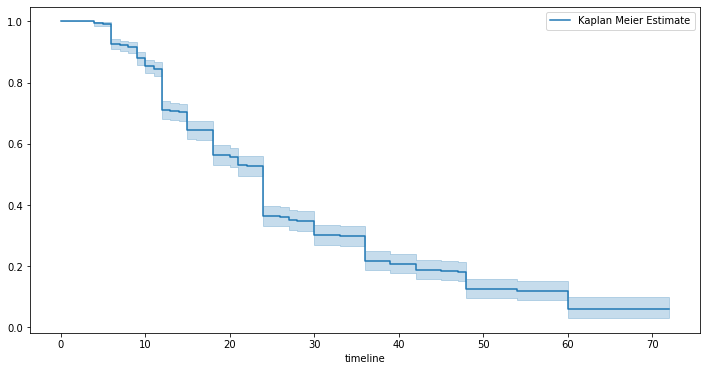

In [11]:
durations = credit['duration'] 
event_observed = credit['credit_risk'] 

km = KaplanMeierFitter() 

km.fit(durations, event_observed,label='Kaplan Meier Estimate')

km.plot();

Now that we have a baseline look at the estimate, let's look at how we can use other features in the dataset to enhance our understanding.

First, let's take a look at how credit history impacts credit risk. We can start by looking at the different possible values that this column has using the `value_counts()` method.

In [12]:
credit["credit_history"].value_counts()

existing credits paid back duly till now       530
critical account/other credits existing        293
delay in paying off in the past                 88
all credits at this bank paid back duly         49
no credits taken/all credits paid back duly     40
Name: credit_history, dtype: int64

We can see that there are 5 different possible values for `credit_history`. Let's take the top 3 and compare their survival curves.

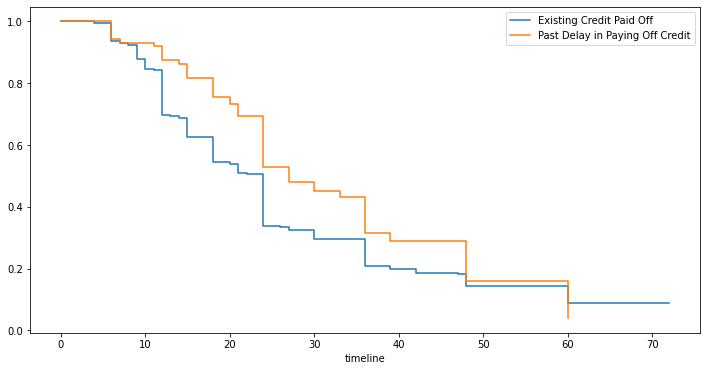

In [13]:
kmf = KaplanMeierFitter() 


T = credit['duration']  
E = credit['credit_risk']     


groups = credit['credit_history']            
ix1 = (groups == 'existing credits paid back duly till now')   
ix2 = (groups == 'delay in paying off in the past')        


kmf.fit(T[ix1], E[ix1], label='Existing Credit Paid Off')   
ax = kmf.plot(ci_show=False)


kmf.fit(T[ix2], E[ix2], label='Past Delay in Paying Off Credit')        
ax = kmf.plot(ax=ax,ci_show=False)           

Here we can see that those with a Past Delay in Paying Off Credit are more likely to be deemed a credit risk sooner.

### Your Turn

Now that we have seen an example of how to use the `lifelines` package, let's look at how telephone ownership impacts credit risk. 

Let's start by using the `value_counts` on the `telephone` column of the `credit` dataframe.

In [14]:
credit["telephone"].value_counts()

no     596
yes    404
Name: telephone, dtype: int64

Now that we have seen the possible values for the `telephone` columns, let's assign `ix1` to the first value from above (no) and the second value (yes) for `ix2`. Make sure you are putting each value in quotes!

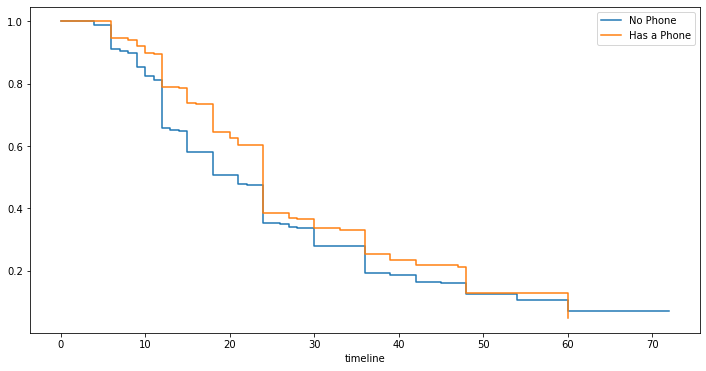

In [15]:
kmf = KaplanMeierFitter() 

T = credit['duration']  
E = credit['credit_risk']     

groups = credit['telephone']            
ix1 = (groups == 'no')   
ix2 = (groups == 'yes')        

kmf.fit(T[ix1], E[ix1], label='No Phone')   
ax = kmf.plot(ci_show=False)


kmf.fit(T[ix2], E[ix2], label='Has a Phone')        
ax = kmf.plot(ax=ax,ci_show=False)           

Question: Those who have a phone are _________ likely to default on their credit.

Fill in the blank with either _more_ or _less_ in the cell below.

_Your answer here_

What are some possible reasons for this to be the case? List 2-3 possible reasons that could cause this difference.

_Your answer here_

You can use the following cell as a scratch cell to play around with the `credit` data. Some strategies to come up with some possible explanations are using the `groupby()` method to see if there are any other differences between phone owners and non phone owners. You can also use matplotlib's `plt.scatter()` method to visualize the data to identify differences. Another way is to look at a few records each of phone owners and non phone owners. 

In [16]:
# This is a scratch cell for the question above

# Survival Regression

Now let's regress other covariates on duration. In this example, we'll be using Cox's proportional hazard model for regression. Cox’s proportional hazard model states that the log-hazard of an individual is a linear function of their covariates and a population-level baseline hazard that changes over time. Mathematically:

$$\underbrace{h(t | x)}_{\text{hazard}} = \overbrace{b_0(t)}^{\text{baseline hazard}} \underbrace{\exp \overbrace{\left(\sum_{i=1}^n b_i (x_i - \overline{x_i})\right)}^{\text{log-partial hazard}}}_ {\text{partial hazard}}$$

Don't worry if you don't fully understand how to math works. It is important to note that the Cox model _does not use an intercept term_ as the baseline hazard represents the intercept. Let's walkthrough an example of survival regression in action.

In [42]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter


cph = CoxPHFitter()
cph.fit(credit, duration_col='duration', event_col='credit_risk', formula ="age + present_residence")

<lifelines.CoxPHFitter: fitted with 1000 total observations, 300 right-censored observations>

Here we have fit a model that looks like

$$duration = \beta_1 * age + \beta_2 * present\_residence$$

We achieve this by adding our right side of the equation to the `formula` parameter in the format of `"variable_1 + variable_2"` as shown above.

Remember that there is no intercept term. We can look at the regression output using the `summary()` method. This regression output should look similar to other ones we have seen in this course and other econometric classes.

In [43]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age,0.009584,1.009630,0.003445,0.002831,0.016337,1.002835,1.016471,0.0,2.781762,0.005406,7.531096
present_residence,-0.051758,0.949559,0.035235,-0.120817,0.017301,0.886196,1.017451,0.0,-1.468953,0.141846,2.817608


Using the coefficients from the table, we can see that our model from above has coefficients:

$$duration = \underbrace{0.009584}_{(0.003445)}* age+  \underbrace{-0.051758}_{(0.035235)}* present\_residence$$

What does this mean in the context of credit default? For every additional year in age, the risk of default increases by 0.009584. For every additional year in the present residence, risk of default is lowered by 0.051758. 

Intuitively, this makes sense, as people who are older and may have retired may be unable to make their payments and default. Similarly, for those who have lived in their present residence for a longer time may indicate that they are better able to make their payments and not default.

## Your Turn

Now's explore how telephone ownership status impacts credit default risk. Use the `age` and `telephone_binary` variables in a regression model. Remember to put a `+` in between each variable in the forumla. Reference the example above if you need a quick reminder on the syntax.

In [45]:
to_replace = {"yes":1,"no":0}
credit["telephone_binary"]=credit["telephone"].replace(to_replace)
credit["foreign_worker_binary"]=credit["foreign_worker"].replace(to_replace)

In [52]:
cph = CoxPHFitter()
cph.fit(credit, duration_col="duration", event_col="credit_risk", formula ="age + telephone_binary")
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age,0.009708,1.009755,0.003325,0.003190,0.016225,1.003195,1.016357,0.0,2.919412,0.003507,8.155578
telephone_binary,-0.245381,0.782407,0.077616,-0.397505,-0.093256,0.671995,0.910960,0.0,-3.161475,0.001570,9.315277


In the cell below, explain the regression summary. How does `age` and `telephone_binary` affect credit default risk? Are the findings significant?

_Your answer here_

Congrats on making it to the end of the lab!